# Advancing Mathematics by Guiding Human Intuition with AI — Knot Theory Path

**Focus:** Reconstructing the discovery path in knot theory from Davies et al., *Nature* (2021)  
**Scope:** We follow how ML-guided exploration suggested a relationship between Vassiliev invariants and the knot signature, and how this informed a conjecture and proof. We **skip** the later part on predicting exponents.

**Big Question:** How can AI surface latent mathematical structure that humans can then formalize and prove?

## Learning Objectives

By the end of this notebook you should be able to:
- Explain what a **knot invariant** is and why such invariants are central to knot classification.
- Describe **Vassiliev (finite-type) invariants** at a high level and the **knot signature** $\sigma(K)$.
- Reproduce, on a small dataset, the **AI-to-conjecture workflow**: from data collection $\rightarrow$ simple models $\rightarrow$ saliency/feature insights $\rightarrow$ human-guided conjecture.
- Articulate the difference between **pattern discovery** and **proof**, and why the latter still requires mathematical reasoning.

In <font color='red'>"Advancing mathematics by guiding human intuition with AI" </font> (Davies et al., 2021) https://www.nature.com/articles/s41586-021-04086-x deep learning (DL) is used to discover mathematical conjectures. The authors propose the following framework. The process involves mathematicians iteratively

*  formulating hypotheses about data,
*  testing these hypotheses with deep learning (DL) models,
*   and then refining their hypotheses based on the results.

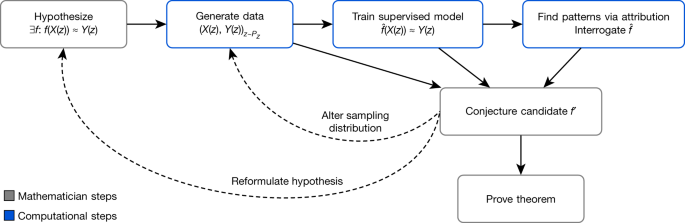

This methodology has led to the discovery of two original mathematical results:

1.  **Knot Theory**: Davies et al., “The signature and cusp geometry of hyperbolic knots.” (2021) [arXiv:2111.15323 ](https://arxiv.org/abs/2111.15323)
2.  **Representation Theory**:  Blundell, Charles D. et al. “Towards combinatorial invariance for Kazhdan-Lusztig polynomials.” [Representation Theory of the American Mathematical Society (2021)](https://www.ams.org/journals/ert/2022-26-37/S1088-4165-2022-00624-8/S1088-4165-2022-00624-8.pdf)

We will use the <ins>knot theory</ins>  example to illustrate the methodology, highlighting the specific AI techniques employed and their application. The <ins>representation theory</ins> case is more complex. Our discussion will draw upon the code available at
https://github.com/google-deepmind/mathematics_conjectures/tree/main  and the discussion in https://arxiv.org/pdf/2112.04324.


## Storyline of the Knot Theory Case

**Intuition.** Mathematicians suspected relationships among different families of invariants but lacked a precise link.

**Data.** Compute/aggregate a table of knot invariants for many low-crossing knots $K$: Vassiliev invariants $v_2, v_3, \dots$, signature $\sigma(K)$, and others.

**AI Hint.** Train simple predictors (linear models / shallow NNs / trees) to estimate one invariant from others; analyze which inputs are most informative.

**Observation.** Signals suggest a tight link between $\text{sign}(v_3)$ (or related finite-type information) and $\sigma(K)$.

**Human Step.** Formulate a precise conjecture and **prove** it using knot-theoretic arguments.

In this notebook, we reproduce this **workflow on a small scale**: not to re-prove results, but to internalize the process of **AI-guided mathematical discovery**.

In [5]:
# Environment & Utils (lightweight, no installs here)
from __future__ import annotations
import sys
import math
import random
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Basic plotting defaults
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120

def section(title: str):
    """Simple helper to print a visible section banner in outputs."""
    print("\n" + "=" * len(title))
    print(title)
    print("=" * len(title))

print(f"Python: {sys.version.split()[0]}")
print(f"Numpy:  {np.__version__}")
print(f"Pandas: {pd.__version__}")

Python: 3.12.11
Numpy:  2.0.2
Pandas: 2.2.2


## What is a Knot?

**Idea/Intuition.**  
A knot is simply a closed loop of string embedded in 3-dimensional space. Think of tying a piece of rope and gluing the ends together. Two knots are considered the same if you can smoothly deform one into the other without cutting the string.

**Formal definition.**  
A knot is an embedding of the circle $S^1$ into $\mathbb{R}^3$, considered up to ambient isotopy (continuous deformation of $\mathbb{R}^3$ that transforms one embedding into another).

**Examples.**
- The **unknot**: a simple circle.  
- The **trefoil knot**: the simplest nontrivial knot.  
- The **figure-eight knot**: another small knot of interest.

We denote knots by their minimal crossing number, e.g. $3_1$ for the trefoil, $4_1$ for the figure-eight.

Knot_table.svg

## Knot Invariants

**Idea/Intuition.**  
A knot invariant is any property of a knot that does not change under deformation. Invariants are the primary tools for distinguishing knots.

**Formal definition.**  
A knot invariant is a function $I$ from the set of knots (up to isotopy) to some set (numbers, polynomials, etc.), such that if two knots $K_1, K_2$ are equivalent, then $I(K_1) = I(K_2)$.

**Examples of invariants:**
- **Crossing number** (minimal number of crossings in any projection).
- **Signature** $\sigma(K)$.
- **Alexander polynomial** $\Delta_K(t)$.
- **Finite-type (Vassiliev) invariants** $v_n(K)$.



Knots possess various invariants, categorized by their mathematical origin.  Two key categories are *algebraic* and *hyperbolic* invariants. This research sought to link the algebraic invariant known as the **signature** to several hyperbolic invariants. This connection between two distinct approaches to knot characterization would be significant.

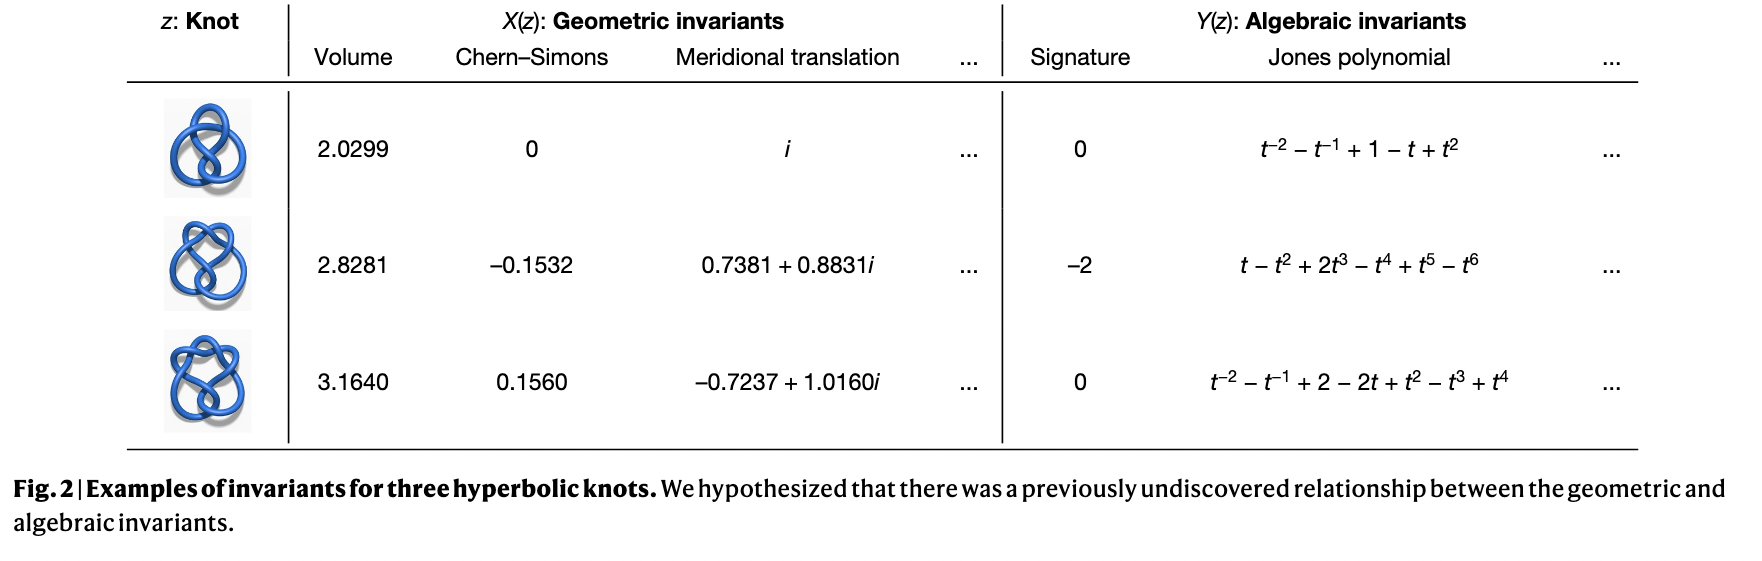

## The Knot Signature

**Idea/Intuition.**  
The signature is a classical integer-valued invariant introduced by Trotter and Murasugi. It can be thought of as capturing an "algebraic orientation balance" of the knot.

**Formal definition (sketch).**  
Given a Seifert surface $F$ for $K$, construct the Seifert matrix $V$.  
The signature is the signature (number of positive minus number of negative eigenvalues) of the symmetrized form $V + V^\top$.

$$
\sigma(K) = \text{signature}(V + V^\top)
$$

**Examples.**
- $\sigma(\text{unknot}) = 0$  
- $\sigma(\text{trefoil}) = \pm 2$ (depending on orientation)  
- $\sigma(\text{figure-eight}) = 0$



1.   Consider an orientable surface $S$ whose boundary is $K$ (a **Seifert surface**). The normal bundle $NS$ of $S$ consists of vectors orthogonal to the tangent space at each point of $S$.


2.   For cycles $a, b \in H_1 (S)$, the **linking number** $\operatorname{lk}(a^{+}, b^{-})$, is computed, where  $a^{+}$ and $b^{-}$ are translates of $a$ and $b$ in the positive and negative directions of the normal bundle $NS$, respectively. Intuitively, $a^{+}$ is a "lift" of $a$ above $S$, and $b^{-}$ is a "lowering" of $b$ below $S$, ensuring they do not intersect. The **linking number** represents the number of times that each curve winds around the other.

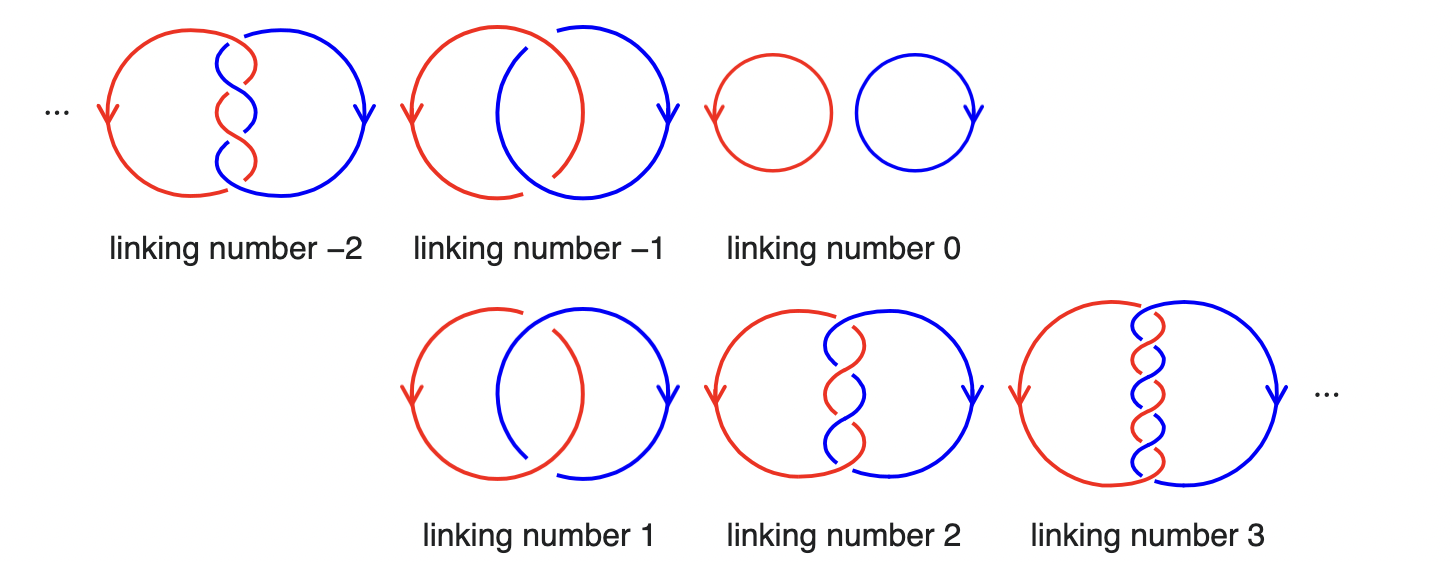

3. The corresponding map  $$\varphi: H_1 (S) \times H_1 (S) \to \mathbb{Z}$$ is called the **Seifert form** of $S$.

4. Choosing a basis $b_{1} \dots b_{2g}$  (where $g$ is the genus of $S$) for the first homology group  $H_{1}(S)$ we can represent the Seifert form by a $2g \times 2g$ **Seifert matrix** $V$, where $$V_{ij} = \varphi(b_i, b_j).$$

5. The <font color='red'> **signature** </font>   of the knot $K$ is the signature of the symmetric matrix $A=V + V^T$. Note that the signature $$\operatorname{sgn}(A) = n_{+} - n_{-} = 2n_{+} - 2g$$ is always an even number.


#  Data Creation

Before AI can help, we need a **rich dataset** of knot invariants.

**Mathematicians’ choice.**  
They selected 19 promising **hyperbolic invariants** as features.  
These capture geometric and symmetry properties of the knot complement.  
Descriptions of each invariant can be found at [KnotInfo](https://knotinfo.math.indiana.edu/).

At this stage, **no AI is involved**. The choice of invariants reflects mathematical experience and intuition.  
Without interesting features, any subsequent modeling would be aimless.

In [21]:
display_name_from_short_name = {
    'chern_simons': 'Chern-Simons',
    'cusp_volume': 'Cusp volume',
    'hyperbolic_adjoint_torsion_degree': 'Adjoint Torsion Degree',
    'hyperbolic_torsion_degree': 'Torsion Degree',
    'injectivity_radius': 'Injectivity radius',
    'longitudinal_translation': 'Longitudinal translation',
    'meridinal_translation_imag': 'Re(Meridional translation)',
    'meridinal_translation_real': 'Im(Meridional translation)',
    'short_geodesic_imag_part': 'Im(Short geodesic)',
    'short_geodesic_real_part': 'Re(Short geodesic)',
    'Symmetry_0': 'Symmetry: $0$',
    'Symmetry_D3': 'Symmetry: $D_3$',
    'Symmetry_D4': 'Symmetry: $D_4$',
    'Symmetry_D6': 'Symmetry: $D_6$',
    'Symmetry_D8': 'Symmetry: $D_8$',
    'Symmetry_Z/2 + Z/2': 'Symmetry: $\\frac{Z}{2} + \\frac{Z}{2}$',
    'volume': 'Volume',
}
column_names = list(display_name_from_short_name)
target = 'signature'

**Scale of the dataset.**

- Initially: ~2 million knots generated.  
- After filtering for successful invariant computation (using specialized software such as **SnapPy**): ~240,000 knots remained.  
- Each knot is represented by 17 hyperbolic invariants (columns), plus the target variable: the **signature**.

This dataset is the raw material for our exploration.

In [23]:
_, input_filename = tempfile.mkstemp()
!gsutil cp "gs://maths_conjectures/knot_theory/knot_theory_invariants.csv" {input_filename}

df = pd.read_csv(input_filename)

Copying gs://maths_conjectures/knot_theory/knot_theory_invariants.csv...
| [1 files][ 48.6 MiB/ 48.6 MiB]                                                
Operation completed over 1 objects/48.6 MiB.                                     


We now have a large table of knots and their hyperbolic invariants.  
Next step: preprocess and normalize the data to make it usable for models.

# Train/Validation/Test Split & Robust Preprocessing

We now prepare the dataset for modeling. Two important principles:

1. **Prevent leakage.** Fit any preprocessing (means, standard deviations, imputers) **only on the training set**, then apply to validation/test.
2. **Respect target distribution.** Since our target is the integer **signature** $\sigma(K)$, we aim for similar distributions across splits. We do this by **stratifying** the split using binned values of $\sigma(K)$.

We will:
- Make a reproducible split (train/validation/test).
- Optionally bin $\sigma(K)$ for stratification.
- Fit normalization on the train set and apply it to validation/test.
- Sanity-check: no zero-variance features within splits, no missing values sneaking in.

Train len: 182809 Val len: 30468 Test len: 30469


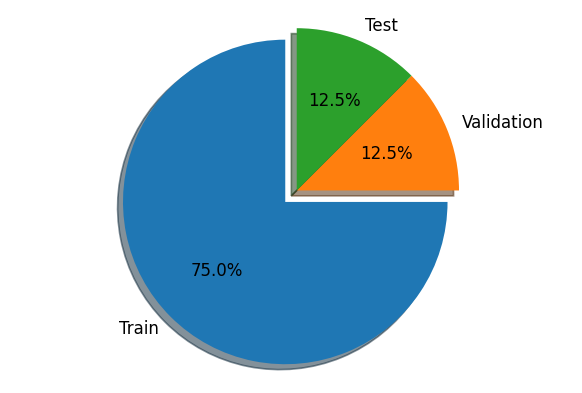

In [24]:
random_seed = 2 # @param {type: "integer"}
random_state = np.random.RandomState(random_seed)
train_df, validation_and_test_df = train_test_split(
    df, random_state=random_state)
validation_df, test_df = train_test_split(
    validation_and_test_df, test_size=.5, random_state=random_state)

import matplotlib.pyplot as plt

print(f'Train len: {len(train_df)}',
      f'Val len: {len(validation_df)}',
      f'Test len: {len(test_df)}')


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Train', 'Validation', 'Test'
sizes = [len(train_df), len(validation_df), len(test_df)]
explode = (0.1, 0, 0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [25]:
# Find bounds for the signature in the training dataset.
max_signature = train_df[target].max()
min_signature = train_df[target].min()
print(f'Max signature: {max_signature}')
print(f'Min signature: {min_signature}')

Max signature: 14
Min signature: -12


### Normalization without leakage

We normalize features using the **training set statistics**:
$$
x' = \frac{x - \mu_{\text{train}}}{\sigma_{\text{train}}}
$$
If a feature has zero variance in the train split, we flag it (such features carry no predictive signal).

We keep the **target** column untouched.

In [26]:
def normalize_features(df, cols, add_target=True):
  features = df[cols]
  sigma = features.std()
  if any(sigma == 0):
    print(sigma)
    raise RuntimeError(
        "A poor data stratification has led to no variation in one of the data "
        "splits for at least one feature (ie std=0). Restratify and try again.")
  mu = features.mean()
  normed_df = (features - mu) / sigma
  if add_target:
    normed_df[target] = df[target]
  return normed_df

def get_batch(df, cols, size=None):
  batch_df = df if size is None else df.sample(size)
  X = batch_df[cols].to_numpy()
  y = batch_df[target].to_numpy()
  return X, y

normed_train_df = normalize_features(train_df, column_names)
normed_validation_df = normalize_features(validation_df, column_names)
normed_test_df = normalize_features(test_df, column_names)
print(normed_train_df.shape, normed_validation_df.shape, normed_test_df.shape)

(182809, 18) (30468, 18) (30469, 18)


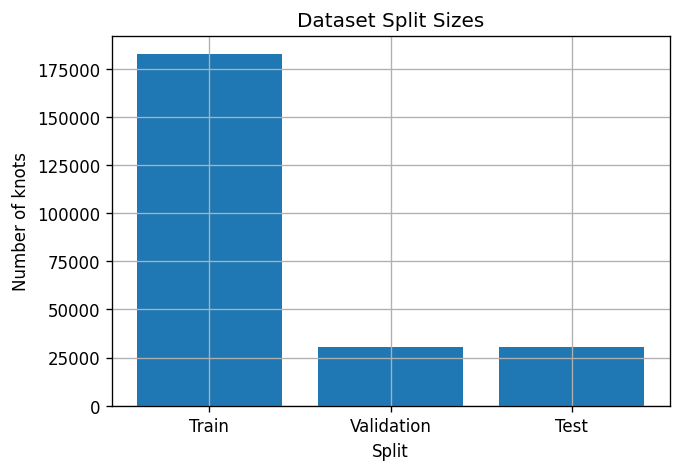

In [27]:
import matplotlib.pyplot as plt

sizes = [len(train_df), len(validation_df), len(test_df)]
labels = ["Train", "Validation", "Test"]

plt.figure()
plt.bar(labels, sizes)
plt.title("Dataset Split Sizes")
plt.xlabel("Split")
plt.ylabel("Number of knots")
plt.show()

# Step 4. Simple model: multiclass prediction of the signature

We cast signature prediction as **multiclass classification**.  
Let $\sigma_{\min}$ and $\sigma_{\max}$ be the minimum and maximum signature values observed in the **training** split (both are even).  
Define the class set
$$
\mathcal{C}=\{0,1,\dots,C-1\},\quad C=\frac{\sigma_{\max}-\sigma_{\min}}{2}+1,
$$
with label mapping
$$
y_{\text{class}}=\frac{\sigma-\sigma_{\min}}{2}\in\mathcal{C},\qquad
\widehat{\sigma}=2\cdot \arg\max \operatorname{softmax}(q) + \sigma_{\min}.
$$

**Architecture (simple DL model).**  
A 3-layer MLP (300 hidden units each, ReLU, optional dropout), output dimension $C$.  
Loss: cross-entropy on class indices (no custom one-hot needed).  
We also compute class weights to mitigate imbalance in $\sigma$.

In [28]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, max_signature, min_signature, input_size=17):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 300),
            nn.Sigmoid(),
            nn.Linear(300, 300),
            nn.Sigmoid(),
            nn.Linear(300, 300),
            nn.Sigmoid(),
            nn.Linear(300, int((max_signature - min_signature) / 2))
        )

    def forward(self, inp):
        return self.layers(inp)

    def predict(self, data_X):
        predictions = self.layers(data_X)
        # Get the predicted class indices
        predicted_classes = torch.argmax(predictions, dim=1)
        # Adjust the predictions based on min_signature
        adjusted_predictions = (predicted_classes * 2 + min_signature)
        return adjusted_predictions

In [35]:
def softmax_cross_entropy(logits, labels, min_signature=min_signature):
    # Ensure all transformed label values are within the valid range
    transformed_labels = (labels - min_signature) // 2
    # Clamp transformed labels to be within [0, num_classes - 1]
    transformed_labels = torch.clamp(transformed_labels, 0, logits.shape[-1] - 1)
    one_hot = torch.nn.functional.one_hot(transformed_labels, num_classes=logits.shape[-1])
    return -torch.sum(torch.nn.functional.log_softmax(logits, dim=-1) * one_hot, dim=-1)

def loss_f(logits, labels):
  return torch.mean(softmax_cross_entropy(logits, labels))

In [36]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_training_steps = 10_000
validation_interval = 100

# Initialize model
model = Net(max_signature=max_signature, min_signature=min_signature)
criterion = loss_f
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
def get_batch(df, feature_cols, size=None):
    """
    Sample a batch of (X, y) from a normalized DataFrame.

    - df: DataFrame with normalized features and raw signature column.
    - feature_cols: list of feature names.
    - size: batch size (if None, use whole df).
    """
    batch_df = df if size is None else df.sample(size)
    X = batch_df[feature_cols].to_numpy(dtype=np.float32)
    # Map signatures to class indices
    y = ((batch_df[target].to_numpy() - min_signature) // 2).astype(int)
    return X, y

In [38]:
def training_loop(model, criterion, optimizer, num_training_steps,
                  validation_interval, normed_train_df, normed_validation_df,
                  normed_test_df, column_names, batch_size, silent=False):
    best_validation_loss = np.inf
    train_losses = []
    val_losses = []
    for i in range(num_training_steps):
        train_X, train_y = get_batch(normed_train_df, column_names, batch_size)
        train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
        train_y_tensor = torch.tensor(train_y, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(train_X_tensor)
        loss = criterion(outputs, train_y_tensor)
        loss.backward()
        optimizer.step()

        if i % validation_interval == 0:
            validation_X, validation_y = get_batch(normed_validation_df, column_names)
            validation_X_tensor = torch.tensor(validation_X, dtype=torch.float32)
            validation_y_tensor = torch.tensor(validation_y, dtype=torch.long)

            with torch.no_grad(): # Disable gradient calculations for validation
                train_loss = criterion(model(train_X_tensor), train_y_tensor)
                validation_loss = criterion(model(validation_X_tensor), validation_y_tensor)
                train_losses.append(train_loss.item())
                val_losses.append(validation_loss.item())
            if not silent:
                print(f"Step count: {i}")
                print(f"Train loss: {train_loss.item()}")
                print(f"Validation loss: {validation_loss.item()}")

            if validation_loss > best_validation_loss:
                print("Validation loss increased. Stopping!")
                break
            else:
                best_validation_loss = validation_loss


    # Test the model
    test_X, test_y = get_batch(normed_test_df, column_names)
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32)

    with torch.no_grad():
        predictions = model.predict(test_X_tensor)
        test_accuracy = np.mean((predictions.numpy() - test_y) == 0)
    if not silent:
      print("Test Accuracy: ", test_accuracy)
    return model, train_losses, val_losses, test_accuracy

# Train the model
trained_model, train_losses, val_losses, test_accuracy = training_loop(model, criterion, optimizer, num_training_steps,
                      validation_interval, normed_train_df,
                      normed_validation_df, normed_test_df, column_names, batch_size)


Step count: 0
Train loss: 2.2912166118621826
Validation loss: 2.32336163520813
Step count: 100
Train loss: 1.0128942728042603
Validation loss: 0.9734093546867371
Step count: 200
Train loss: 0.27422186732292175
Validation loss: 0.29115599393844604
Step count: 300
Train loss: 0.2634778916835785
Validation loss: 0.23141388595104218
Step count: 400
Train loss: 0.2565045654773712
Validation loss: 0.21362921595573425
Step count: 500
Train loss: 0.34103256464004517
Validation loss: 0.20885682106018066
Step count: 600
Train loss: 0.28503021597862244
Validation loss: 0.2052692323923111
Step count: 700
Train loss: 0.2541666030883789
Validation loss: 0.2494838684797287
Validation loss increased. Stopping!
Test Accuracy:  0.41858938593324363


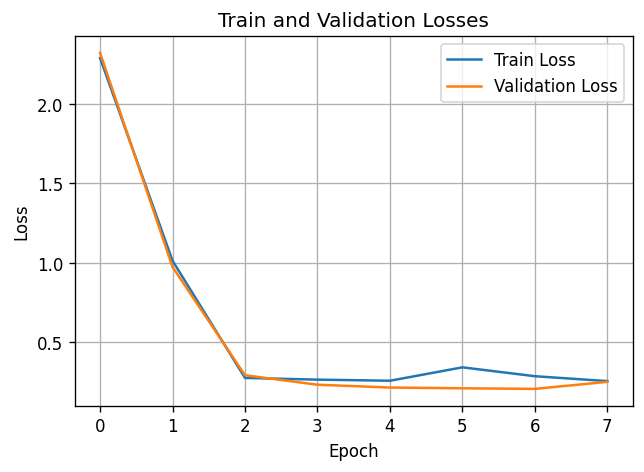

In [39]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()

In [40]:
print(test_accuracy)

0.41858938593324363


# Step 3 . Train Neural Network




*   A neural network (3 hidden layers, 300 units in each, fully connected) was trained on the data.

The network predicts a categorical distribution, represented by a vector $q$. The i-th element of $\operatorname{softmax}(q)$,  gives the predicted probability that the knot's signature is equal to $2*i + \operatorname{min\_signature}$. (Knot signatures are always even integers).


*   A **simple DL model** was used on this step.

In [41]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, max_signature, min_signature, input_size=17):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 300),
            nn.Sigmoid(),
            nn.Linear(300, 300),
            nn.Sigmoid(),
            nn.Linear(300, 300),
            nn.Sigmoid(),
            nn.Linear(300, int((max_signature - min_signature) / 2))
        )

    def forward(self, inp):
        return self.layers(inp)

    def predict(self, data_X):
        predictions = self.layers(data_X)
        # Get the predicted class indices
        predicted_classes = torch.argmax(predictions, dim=1)
        # Adjust the predictions based on min_signature
        adjusted_predictions = (predicted_classes * 2 + min_signature)
        return adjusted_predictions


We take the cross entropy between this distribution and the true distribution
 (i.e. 1 at the true value of the signature, 0 everywhere else) as the loss function.

In [ ]:
def softmax_cross_entropy(logits, labels, min_signature=min_signature):
    # Ensure all transformed label values are within the valid range
    transformed_labels = (labels - min_signature) // 2
    # Clamp transformed labels to be within [0, num_classes - 1]
    transformed_labels = torch.clamp(transformed_labels, 0, logits.shape[-1] - 1)
    one_hot = torch.nn.functional.one_hot(transformed_labels, num_classes=logits.shape[-1])
    return -torch.sum(torch.nn.functional.log_softmax(logits, dim=-1) * one_hot, dim=-1)

def loss_f(logits, labels):
  return torch.mean(softmax_cross_entropy(logits, labels))

### Model + Loss + Optmizer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_training_steps = 10_000
validation_interval = 100

# Initialize model
model = Net(max_signature=max_signature, min_signature=min_signature)
criterion = loss_f
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Training loop

We train for num_training_steps or until the validation loss rises.

In [ ]:
def training_loop(model, criterion, optimizer, num_training_steps,
                  validation_interval, normed_train_df, normed_validation_df,
                  normed_test_df, column_names, batch_size, silent=False):
    best_validation_loss = np.inf
    train_losses = []
    val_losses = []
    for i in range(num_training_steps):
        train_X, train_y = get_batch(normed_train_df, column_names, batch_size)
        train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
        train_y_tensor = torch.tensor(train_y, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(train_X_tensor)
        loss = criterion(outputs, train_y_tensor)
        loss.backward()
        optimizer.step()

        if i % validation_interval == 0:
            validation_X, validation_y = get_batch(normed_validation_df, column_names)
            validation_X_tensor = torch.tensor(validation_X, dtype=torch.float32)
            validation_y_tensor = torch.tensor(validation_y, dtype=torch.long)

            with torch.no_grad(): # Disable gradient calculations for validation
                train_loss = criterion(model(train_X_tensor), train_y_tensor)
                validation_loss = criterion(model(validation_X_tensor), validation_y_tensor)
                train_losses.append(train_loss.item())
                val_losses.append(validation_loss.item())
            if not silent:
                print(f"Step count: {i}")
                print(f"Train loss: {train_loss.item()}")
                print(f"Validation loss: {validation_loss.item()}")

            if validation_loss > best_validation_loss:
                print("Validation loss increased. Stopping!")
                break
            else:
                best_validation_loss = validation_loss


    # Test the model
    test_X, test_y = get_batch(normed_test_df, column_names)
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32)

    with torch.no_grad():
        predictions = model.predict(test_X_tensor)
        test_accuracy = np.mean((predictions.numpy() - test_y) == 0)
    if not silent:
      print("Test Accuracy: ", test_accuracy)
    return model, train_losses, val_losses, test_accuracy

# Train the model
trained_model, train_losses, val_losses, test_accuracy = training_loop(model, criterion, optimizer, num_training_steps,
                      validation_interval, normed_train_df,
                      normed_validation_df, normed_test_df, column_names, batch_size)


Step count: 0
Train loss: 2.2924935817718506
Validation loss: 2.3594322204589844
Step count: 100
Train loss: 1.4061917066574097
Validation loss: 1.3930184841156006
Step count: 200
Train loss: 0.6688843369483948
Validation loss: 0.5585750937461853
Step count: 300
Train loss: 0.3851040303707123
Validation loss: 0.4838934540748596
Step count: 400
Train loss: 0.4127418100833893
Validation loss: 0.45159798860549927
Step count: 500
Train loss: 0.4464116394519806
Validation loss: 0.4483409821987152
Step count: 600
Train loss: 0.26830312609672546
Validation loss: 0.42915037274360657
Step count: 700
Train loss: 0.38341137766838074
Validation loss: 0.40204840898513794
Step count: 800
Train loss: 0.39862945675849915
Validation loss: 0.4207070767879486
Validation loss increased. Stopping!
Test Accuracy:  0.8290393514719879


Train and Validation losses

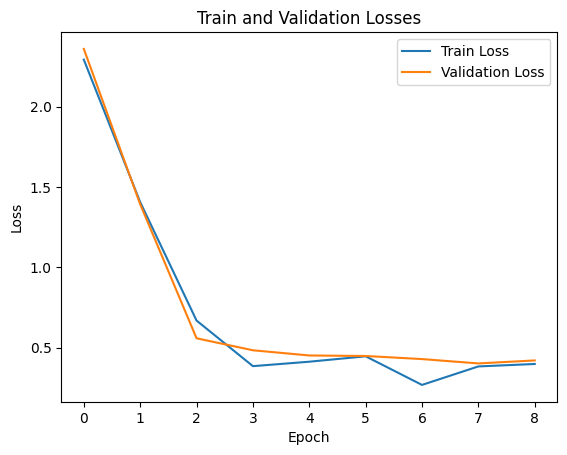

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()

The trained neural network predicted the signature from the hyperbolic invariants with over 75% accuracy, suggesting a previously unknown relationship.

In [ ]:
print(test_accuracy)

0.8290393514719879


## Step-4 Feature selection (Salencies)



Feature selection was performed using saliency.  **Saliency** was calculated by averaging the gradient of the loss function with respect to each input feature (knot invariant) across the dataset.

Saliency analysis identifies the features in a dataset that most influence the model's output, $f(x)$. It quantifies feature importance by calculating the gradient,  $\frac{\partial f(x)}{\partial x_i}$, of the output with respect to each input feature, $x_i$. Larger gradient magnitudes $\left|\frac{\partial f(x)}{\partial x_i}\right|$ indicate higher saliency, meaning that changes in $x_i$ strongly affect the prediction.


*   While we used a **simple DL** approach for feature selection, other statistical methods could be employed with this relatively small feature set (17 features).  Exhaustive search of all feature combinations is also a possibility.


In [42]:
test_X, test_y = get_batch(normed_test_df, column_names)
# without size we take the whole test dataset
assert test_X.shape[0] == test_y.shape[0]
assert test_X.shape[0]  == normed_test_df.shape[0]

test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.long)

# 1. Set the model to evaluation mode
trained_model.eval()

# 2. Calculate gradients
test_X_tensor.requires_grad_(True) # Enable gradient calculation for input features
outputs = trained_model(test_X_tensor)
loss = criterion(outputs, test_y_tensor)

# Calculate gradients of the loss with respect to the input
loss.backward()

# Extract saliencies (gradients of the loss with respect to the input features)
saliencies = test_X_tensor.grad.abs().mean(dim=0)

# Now 'saliencies' is a tensor containing the saliency scores for each input feature.
saliencies

tensor([8.6163e-08, 9.1719e-07, 3.7065e-07, 6.5511e-07, 1.2463e-06, 1.1348e-05,
        1.0845e-05, 2.1637e-05, 1.5279e-06, 1.0079e-06, 4.2762e-07, 5.8914e-07,
        4.4482e-07, 6.5070e-07, 6.9957e-07, 5.0219e-07, 8.0323e-07])



The resulting saliencies, plotted in descending order, should demonstrate that the following 3 invariants have a disproportionately large influence on the overall loss:


1.   longitudinal translation,
2.   the real part of the meridional translation,
3.  the imaginary part of the meridional translation.






In [44]:
import seaborn as sns

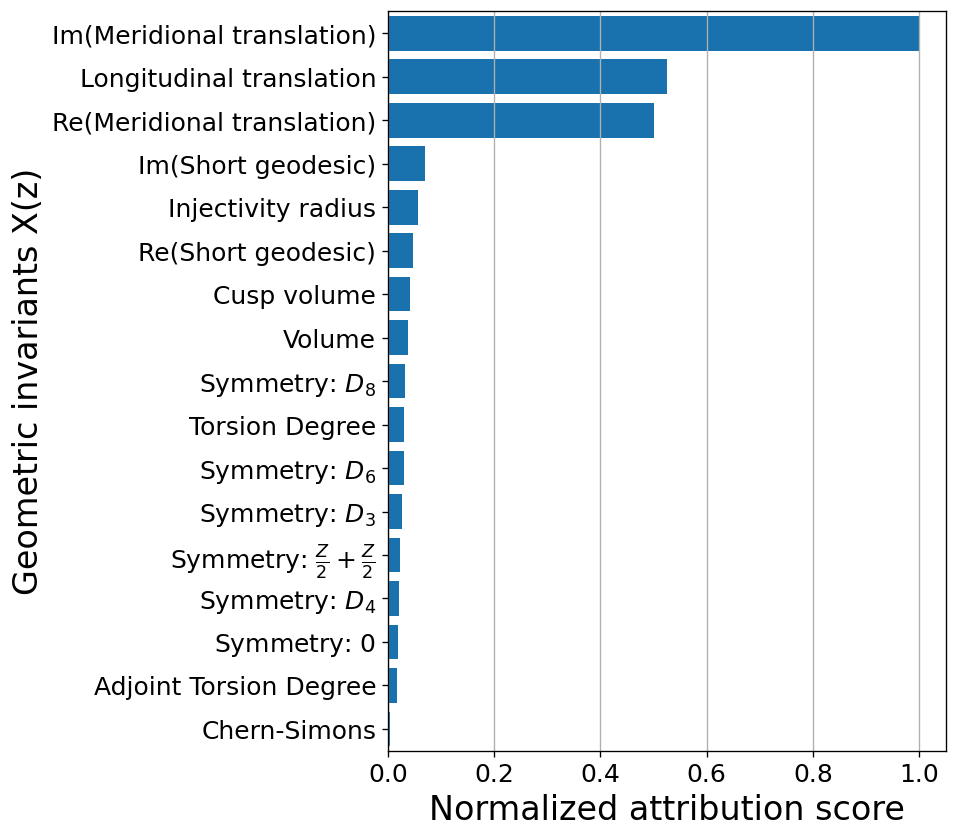

In [45]:
decreasing_saliency = reversed(sorted(zip(saliencies, display_name_from_short_name.values())))
sorted_saliencies, sorted_columns = zip(*decreasing_saliency)

fig, ax = plt.subplots(figsize=(6,8))
sns.barplot(y=np.array(sorted_columns),
            x=np.array(sorted_saliencies) / max(sorted_saliencies),
            color="#0077c6");

ax.tick_params(labelsize=15);
ax.set_ylabel('Geometric invariants X(z)', fontsize=20);
plt.xlabel('Normalized attribution score', fontsize=20);

## Step-5 Feature analysis

Analyzing the data, the mathematicians introduced ``**natural slope**'', defined to be $$\operatorname{slope}(K) = \operatorname{Re}\left(\frac{\lambda}{\mu}\right),$$ where
$\operatorname{Re}$ denotes the real part. It has the following geometric interpretation.
One can realize the meridian curve as a geodesic $\gamma$ on the Euclidean
torus $\mathbb{T}^2$. If one fires off a geodesic $\gamma^{\perp}$ from this orthogonally, it will eventually return and hit $\gamma$ at some point. In doing so, it will have travelled
along a longitude minus some multiple of the meridian. This multiple
is the natural slope. It need not be an integer, because the endpoint of
$\gamma^{\perp}$ might not be the same as its starting point.
  



In [46]:
def predict_signature_from_slope(data_X, min_signature, max_signature):
  meridinal_translation = (
      data_X['meridinal_translation_real'] +
      1j * data_X['meridinal_translation_imag'])
  slope = data_X['longitudinal_translation'] / meridinal_translation
  return slope.real / 2


*   This new invariant $\operatorname{slope}(K)$ is shown to be approximately twice the signature (plus a correction term).



Text(0, 0.5, 'Signature')

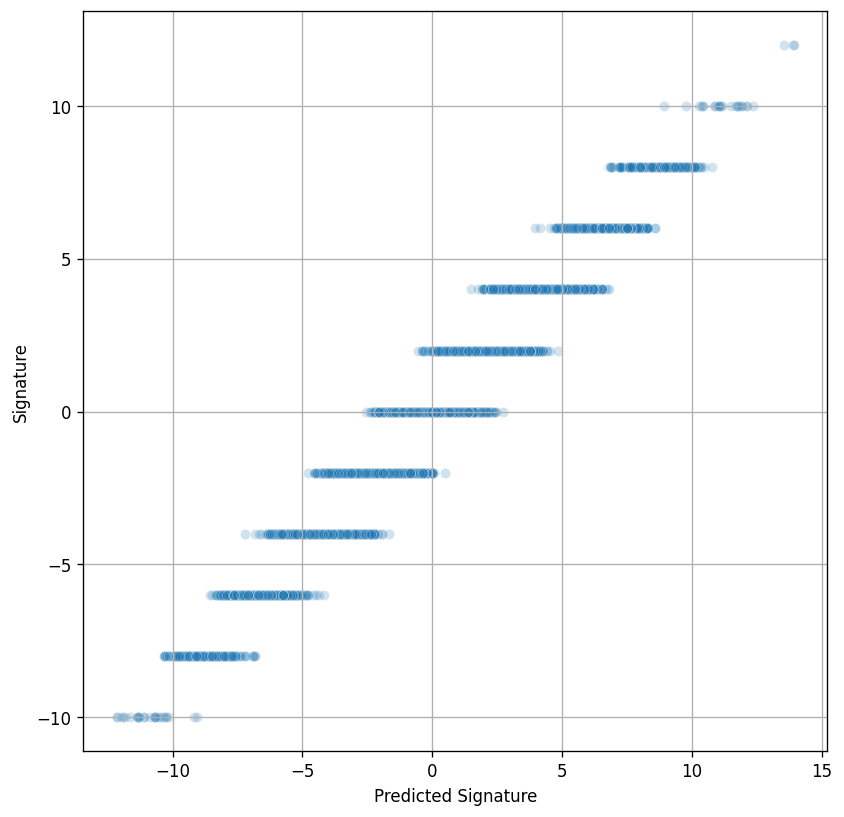

In [47]:
predictions = [
    predict_signature_from_slope(x, min_signature, max_signature)
    for _, x in test_df.iterrows()
]

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x=predictions, y=test_df[target], alpha=0.2)
ax.set_xlabel('Predicted Signature')
ax.set_ylabel('Signature')

Using the slope as the
sole predictive feature for the signature gave an accuracy of $78\%$; i.e. the slope constituted all the
predictive power in the twelve hyperbolic features combined. In order to compute the "test accuracy" in the same way as before, we quantize predicted signature values to even integers, between min_signature and  max_signature.

In [48]:
def quantize(x, min_signature, max_signature):
  return min(max(2 * round(x / 2), min_signature), max_signature)

quantized_predictions = [
    quantize(x, min_signature, max_signature) for x in predictions
]

The below accuracy will probably be lower than the previous ~80%, but not by much, likely still >70%


In [49]:
print("Test Accuracy: ", np.mean(test_df[target] - quantized_predictions == 0))

Test Accuracy:  0.738192917391447


## Step-6 Hypothesis formulation.

The mathematicians  formulated an initial hypothesis:

> **Conjecture**: There exist constants $c_1$ and $c_2$ such that, for every hyperbolic knot $K$, $$\left| 2 \sigma(K) - \operatorname{slope}(K) \right| < c_1 \operatorname{vol}(K) + c_2. $$


They realized that there might be counter-examples to the initial hypothesis over a
particular category of knots. They generated a data set with about 36,000 knots in this category.
They indeed found some counter-examples. Finally, they were able to establish a relationship between $\operatorname{slope}(K)$, signature $\sigma(K)$, volume $\operatorname{vol}(K)$ and one of the next most salient geometric invariants, the injectivity radius $\operatorname{inj}(K)$.


> **Theorem:** There exists a constant $c$ such that, for any hyperbolic knot $K$, $$\left|2\sigma(K) - \operatorname{slope}(K) \right| \leq c \frac{ \operatorname{vol}(K)}{\operatorname{inj}(K)^3}. $$



# Conclusion



*   In this knot theory research DL a role only in Step-3 (Training NN). The features could probably be selected using other statistical methods.
*   Constructions of datasets relied on specialized, computationally intensive software.  The remaining steps were human-driven.  
*   Found relationship had a simple form $$\sigma \approx \frac{\lambda a}{2(a^2 + b^2)}.$$ However, it only established predictability (78% accuracy), not the formula itself.


This highlights a challenge for deep learning in mathematics. Roughly speaking, it provides the following information:

>  After looking at millions of examples, there is a pattern that works $X\%$ of the time, mostly on the basis of features $A,B,C$.


*  <font color='blue'>**Question (for discussion):**</font> How useful can such results be in mathematics?


# 1. Eigenvalues of symmetric matrices

This section utilizes the standard neural network training loop.  As the code is straightforward, we can proceed quickly.

- A key advantage of neural networks, demonstrated here, is their ability to approximate a wide range of functions, including those with multiple outputs.

Consider predicting the eigenvalues of 3x3 symmetric matrices.   The input vector consists of elements on and above the diagonal, and the target is the eigenvalue vector: $$M_i = \left(\begin{matrix} a & b  & c \\ b & d & e \\ c & e & f\end{matrix} \right) \quad \to \quad x_i= \left( a, b, c, d, e, f\right), \quad y_i = (\lambda_1, \lambda_2, \lambda_2).$$ We generate 10k matrices with all values from -10 to 10.


In [ ]:
def generate_symmetric_matrix(min_val=-10.0, max_val=10.0, dim=3):
  """Generates a random symmetric matrix of the specified dimension."""
  matrix = np.random.uniform(min_val, max_val, size=(dim, dim))
  return (matrix + matrix.T) / 2

# Generate 10k 3x3 symmetric matrices
num_matrices = 10000
dim = 3
data = []
for _ in tqdm(range(num_matrices)):
  matrix = generate_symmetric_matrix(dim=dim)
  row = []
  for i in range(dim):
    for j in range(i+1):
      row.append(matrix[i, j])
  w, _ = np.linalg.eig(matrix)
  row.extend(np.sort(w))
  data.append(row)

# Create a Pandas DataFrame
df = pd.DataFrame(data)

print()
print(df.head())

100%|██████████| 10000/10000 [00:01<00:00, 9208.58it/s]



          0         1         2         3         4         5          6  \
0  5.438764  3.245256  7.992729  0.080822 -6.211529 -0.113366  -3.777797   
1 -2.657174  3.717008  7.633463  5.484480  6.684797 -2.247552  -8.287276   
2  1.222596 -0.534163  4.046218  2.503763 -6.408687 -8.996344 -11.960512   
3 -4.864247 -2.022647  4.821908 -1.979828  0.479122 -0.244158  -5.881991   
4  4.430787 -2.131381  2.309509  0.654401  1.974357 -2.843735  -3.734711   

          7          8  
0  4.591179  12.504746  
1 -2.179353  13.195366  
2  1.191866   7.041115  
3  0.228752   5.366742  
4  1.850370   5.780902  


**Recommendation**: Neural networks fail silently.  Verify calculations (e.g., matrix dimensions) to catch potential errors.

In [ ]:
assert df.shape == (num_matrices, dim * (dim + 1) // 2 + dim)

Number of elements in train set: 8000
Number of elements in test set: 2000


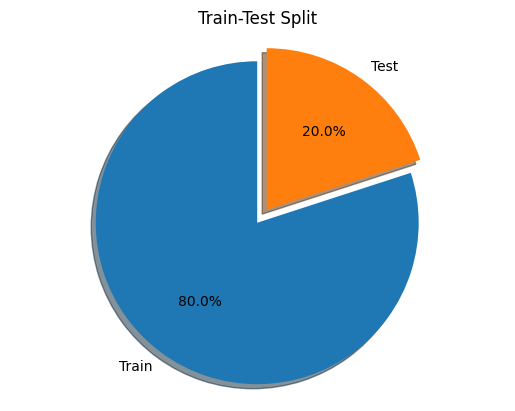

In [ ]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)

# Calculate the sizes of the training and testing sets
train_size = len(train_df)
test_size = len(test_df)

print(f"Number of elements in train set: {train_size}")
print(f"Number of elements in test set: {test_size}")

# Create a pie chart
labels = ['Train', 'Test']
sizes = [train_size, test_size]
explode = (0.1, 0)  # Explode the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Train-Test Split')
plt.show()


## 1.1 Baseline (Linear Regressions)

A multi-head model can be constructed using a shared body and separate heads.  Here, we use polynomial features for the body and linear regression for each head, predicting individual eigenvalues. This approach reduces computation and the number of parameters.

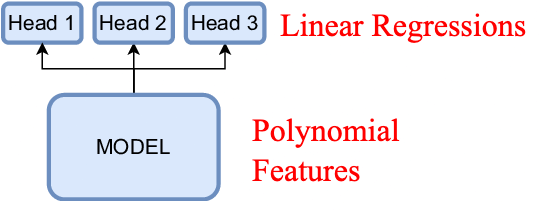

Train-test split:

In [ ]:
# Prepare the data
X = df.iloc[:, :6]  # First 6 columns as features
y = df.iloc[:, -3:]  # Last 3 columns as targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


We train polynomial regression as a baseline.

100%|██████████| 7/7 [00:24<00:00,  3.45s/it]



[6.688269487712515, 2.9688931451859406, 0.558917916598426, 0.47049824438189086, 0.18625928231536737, 0.17288405839487012, 0.13481539047064126]


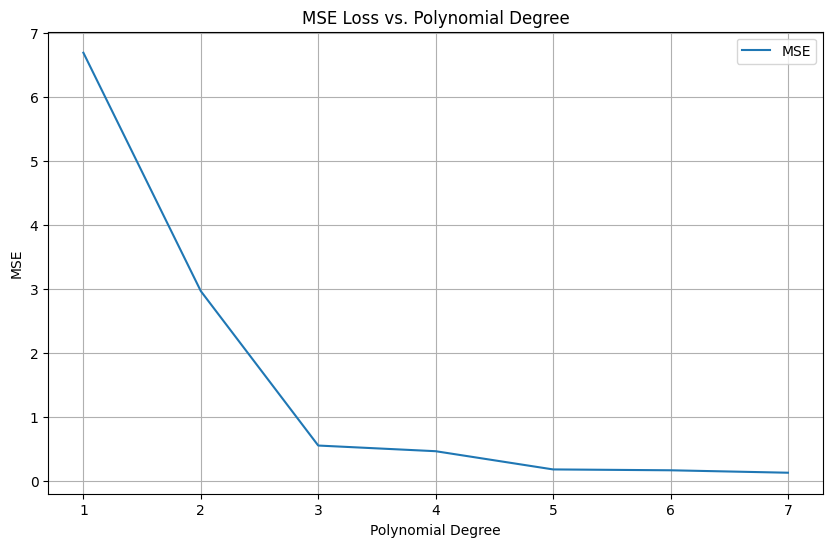

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize lists to store MSE values
mse_values = []
degrees = []

max_deg = 8
mse_values = []
degrees = []
# Loop through polynomial degrees and train/evaluate models for each target
for degree in tqdm(range(1, max_deg)):  # polynomial degree from 1 to 10
    y_pred = []
    degrees.append(degree)
    for target_index in range(dim):  # Iterate over the three target columns
        poly = PolynomialFeatures(degree=degree)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)

        model = LinearRegression()
        model.fit(X_poly_train, y_train.iloc[:, target_index])
        y_pred.append(model.predict(X_poly_test))

    y_pred = np.stack(y_pred, axis=1)
    assert y_pred.shape == y_test.shape

    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# Plotting MSE values for each target variable
print()
print(mse_values)
plt.figure(figsize=(10, 6))
plt.plot(degrees, mse_values, label = 'MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE Loss vs. Polynomial Degree')
plt.legend()
plt.grid(True)
plt.show()

Test Loss:

In [ ]:
loss_dict = {}
loss_dict["Poly reg loss"] = np.min(mse_values)
print(mse_values[-1])

0.13481539047064126


## 1.2 Simple Neural Network

Normalize data:

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform both training and testing data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to Pytorch Tensors
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train.numpy(), dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test.numpy(), dtype=torch.float32)

Next, we train Neural Network

In [ ]:
# Define the neural network architecture
class EigenvalueNet(nn.Module):
    def __init__(self, dim=3):
        super(EigenvalueNet, self).__init__()
        input_size = dim * (dim + 1) // 2
        self.fc1 = nn.Linear(input_size , 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Create an instance of the neural network
model = EigenvalueNet()

In [ ]:
def training_loop(model, X_train, y_train, X_test, y_test, criterion,
                  optimizer, num_epochs=100, batch_size=64,  print_loss=True,
                  print_grad = False):
    train_losses = []
    test_losses = []

    # Set in training mode
    model.train()
    for epoch in tqdm(range(num_epochs)):
      for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      # Print progress
      if print_loss and epoch % 20 == 9:
        print(f' Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        if print_grad:
            for name, param in model.named_parameters():
                if param.grad is not None:
                    print(f"Layer: {name}, Gradient: {param.grad.norm()}")
            print()
      train_losses.append(loss.item())

      # Set in evaluation mode and evaluate
      model.eval()
      with torch.no_grad():
        predicted_eigenvalues = model(X_test)
        test_loss = criterion(predicted_eigenvalues, y_test)
        test_losses.append(test_loss.item())

    return train_losses, test_losses

In [ ]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = training_loop(model, X_train_scaled, y_train,
                                              X_test_scaled, y_test,
                                              criterion, optimizer)

 11%|█         | 11/100 [00:01<00:13,  6.42it/s]

 Epoch [10/100], Loss: 0.6593


 30%|███       | 30/100 [00:05<00:15,  4.41it/s]

 Epoch [30/100], Loss: 0.1200


 51%|█████     | 51/100 [00:08<00:07,  6.46it/s]

 Epoch [50/100], Loss: 0.0898


 71%|███████   | 71/100 [00:11<00:04,  6.40it/s]

 Epoch [70/100], Loss: 0.0767


 91%|█████████ | 91/100 [00:14<00:01,  6.02it/s]

 Epoch [90/100], Loss: 0.0662


100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


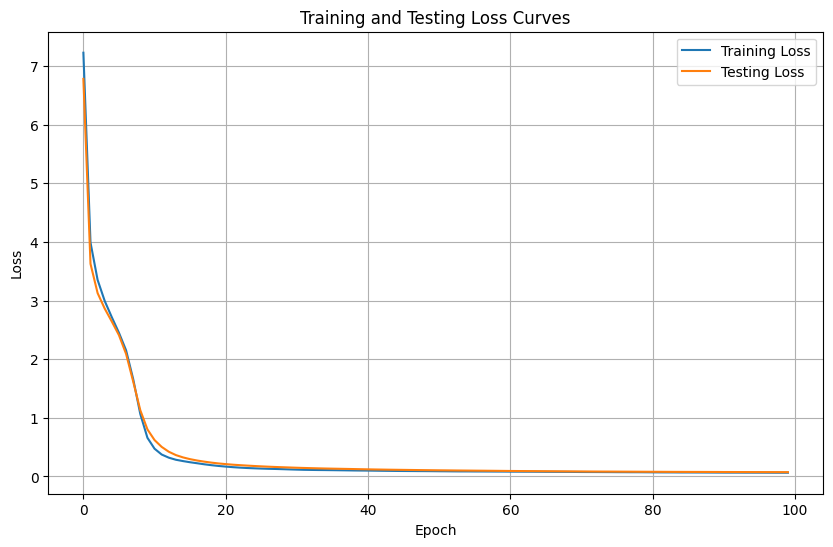

In [ ]:
import matplotlib.pyplot as plt
# Plotting the training and testing losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

We got better MSE loss

In [ ]:
loss_dict["Simple NN loss"] = test_losses[-1]
print(test_losses[-1])

0.07338964939117432


## 1.2 Deep Neural Networks

Why do we study Neural Networks? A fundamental reason for the success of neural networks is the **Universal Approximation Theorem** (for details see https://en.wikipedia.org/wiki/Universal_approximation_theorem). One of the version states:

 > Feedforward networks with non-polynomial activation functions are dense in the space of continuous functions between two Euclidean spaces.

Note that these theorems do not guarantee that any specific network size, such as 10,000 neurons, will suffice.

As an experiment, let's construct a substantially larger neural network and examine its performance characteristics.

### 1.2.1 Big Neural Network

There can be an idea that we can take a big Neural Network and get good results.

In [ ]:
dim = 3
input_size, hidden_size, output_size = dim * (dim + 1) // 2, 32, dim

big_model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)

In [ ]:
summary(big_model, (6,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             224
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 32]           1,056
              ReLU-6                   [-1, 32]               0
            Linear-7                   [-1, 32]           1,056
              ReLU-8                   [-1, 32]               0
            Linear-9                   [-1, 32]           1,056
             ReLU-10                   [-1, 32]               0
           Linear-11                   [-1, 32]           1,056
             ReLU-12                   [-1, 32]               0
           Linear-13                   [-1, 32]           1,056
             ReLU-14                   

### 1.2.2 Training loop

Let's train it.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=0.001)
big_train_loss, big_test_loss = training_loop(big_model, X_train_scaled, y_train,
                                              X_test_scaled, y_test,
                                              criterion, optimizer, num_epochs=200,
                                              print_grad=True)

  5%|▌         | 10/200 [00:05<01:28,  2.14it/s]

 Epoch [10/200], Loss: 13.7413
Layer: 0.weight, Gradient: 0.8051308393478394
Layer: 0.bias, Gradient: 0.22239400446414948
Layer: 2.weight, Gradient: 0.5264986753463745
Layer: 2.bias, Gradient: 0.14176765084266663
Layer: 4.weight, Gradient: 0.33217883110046387
Layer: 4.bias, Gradient: 0.07120189070701599
Layer: 6.weight, Gradient: 0.5190393924713135
Layer: 6.bias, Gradient: 0.05251536890864372
Layer: 8.weight, Gradient: 0.4895921051502228
Layer: 8.bias, Gradient: 0.03937358781695366
Layer: 10.weight, Gradient: 0.505439817905426
Layer: 10.bias, Gradient: 0.03463267162442207
Layer: 12.weight, Gradient: 0.5341931581497192
Layer: 12.bias, Gradient: 0.031832024455070496
Layer: 14.weight, Gradient: 0.5808699131011963
Layer: 14.bias, Gradient: 0.03127492964267731
Layer: 16.weight, Gradient: 0.684708833694458
Layer: 16.bias, Gradient: 0.03244726359844208
Layer: 18.weight, Gradient: 1.407576560974121
Layer: 18.bias, Gradient: 0.054591961205005646
Layer: 20.weight, Gradient: 3.654500961303711
Lay

 15%|█▌        | 30/200 [00:13<01:20,  2.12it/s]

 Epoch [30/200], Loss: 3.3446
Layer: 0.weight, Gradient: 2.7544384002685547
Layer: 0.bias, Gradient: 2.3333888053894043
Layer: 2.weight, Gradient: 4.633742809295654
Layer: 2.bias, Gradient: 1.8636702299118042
Layer: 4.weight, Gradient: 6.849358558654785
Layer: 4.bias, Gradient: 1.1775448322296143
Layer: 6.weight, Gradient: 9.572444915771484
Layer: 6.bias, Gradient: 0.7602360248565674
Layer: 8.weight, Gradient: 10.945453643798828
Layer: 8.bias, Gradient: 0.7155779004096985
Layer: 10.weight, Gradient: 9.038969993591309
Layer: 10.bias, Gradient: 0.5758456587791443
Layer: 12.weight, Gradient: 20.537708282470703
Layer: 12.bias, Gradient: 1.151759386062622
Layer: 14.weight, Gradient: 20.007503509521484
Layer: 14.bias, Gradient: 0.8765745162963867
Layer: 16.weight, Gradient: 11.353841781616211
Layer: 16.bias, Gradient: 0.37031373381614685
Layer: 18.weight, Gradient: 10.800766944885254
Layer: 18.bias, Gradient: 0.2616555690765381
Layer: 20.weight, Gradient: 10.748361587524414
Layer: 20.bias, G

 25%|██▌       | 50/200 [00:23<01:03,  2.35it/s]

 Epoch [50/200], Loss: 2.9986
Layer: 0.weight, Gradient: 2.476541519165039
Layer: 0.bias, Gradient: 2.0828492641448975
Layer: 2.weight, Gradient: 3.7796905040740967
Layer: 2.bias, Gradient: 1.3845548629760742
Layer: 4.weight, Gradient: 4.949039936065674
Layer: 4.bias, Gradient: 0.8091162443161011
Layer: 6.weight, Gradient: 7.402113437652588
Layer: 6.bias, Gradient: 0.6268255710601807
Layer: 8.weight, Gradient: 8.267759323120117
Layer: 8.bias, Gradient: 0.5921574234962463
Layer: 10.weight, Gradient: 7.407843589782715
Layer: 10.bias, Gradient: 0.5308240056037903
Layer: 12.weight, Gradient: 15.78812026977539
Layer: 12.bias, Gradient: 1.022149682044983
Layer: 14.weight, Gradient: 16.53719711303711
Layer: 14.bias, Gradient: 0.8734155297279358
Layer: 16.weight, Gradient: 9.259613990783691
Layer: 16.bias, Gradient: 0.36507129669189453
Layer: 18.weight, Gradient: 9.345499992370605
Layer: 18.bias, Gradient: 0.2794359028339386
Layer: 20.weight, Gradient: 7.890499114990234
Layer: 20.bias, Gradien

 35%|███▌      | 70/200 [00:32<00:56,  2.29it/s]

 Epoch [70/200], Loss: 2.9005
Layer: 0.weight, Gradient: 2.2959518432617188
Layer: 0.bias, Gradient: 1.8211402893066406
Layer: 2.weight, Gradient: 3.5025079250335693
Layer: 2.bias, Gradient: 1.2183756828308105
Layer: 4.weight, Gradient: 4.291624546051025
Layer: 4.bias, Gradient: 0.7203323245048523
Layer: 6.weight, Gradient: 6.110575199127197
Layer: 6.bias, Gradient: 0.5620641112327576
Layer: 8.weight, Gradient: 6.679194450378418
Layer: 8.bias, Gradient: 0.5240306854248047
Layer: 10.weight, Gradient: 5.996589183807373
Layer: 10.bias, Gradient: 0.469716340303421
Layer: 12.weight, Gradient: 12.347128868103027
Layer: 12.bias, Gradient: 0.8930193185806274
Layer: 14.weight, Gradient: 13.253226280212402
Layer: 14.bias, Gradient: 0.7811416387557983
Layer: 16.weight, Gradient: 7.506095886230469
Layer: 16.bias, Gradient: 0.32635271549224854
Layer: 18.weight, Gradient: 7.480595111846924
Layer: 18.bias, Gradient: 0.24744616448879242
Layer: 20.weight, Gradient: 6.581636428833008
Layer: 20.bias, Gra

 45%|████▌     | 90/200 [00:41<00:52,  2.09it/s]

 Epoch [90/200], Loss: 2.8027
Layer: 0.weight, Gradient: 2.0886783599853516
Layer: 0.bias, Gradient: 1.4473196268081665
Layer: 2.weight, Gradient: 2.973104238510132
Layer: 2.bias, Gradient: 0.9979364275932312
Layer: 4.weight, Gradient: 3.3115155696868896
Layer: 4.bias, Gradient: 0.5778246521949768
Layer: 6.weight, Gradient: 4.598410129547119
Layer: 6.bias, Gradient: 0.46287068724632263
Layer: 8.weight, Gradient: 4.974782466888428
Layer: 8.bias, Gradient: 0.4286321699619293
Layer: 10.weight, Gradient: 4.605575084686279
Layer: 10.bias, Gradient: 0.39163824915885925
Layer: 12.weight, Gradient: 9.234332084655762
Layer: 12.bias, Gradient: 0.7251728177070618
Layer: 14.weight, Gradient: 10.11120891571045
Layer: 14.bias, Gradient: 0.6471635103225708
Layer: 16.weight, Gradient: 5.818169593811035
Layer: 16.bias, Gradient: 0.2734014689922333
Layer: 18.weight, Gradient: 5.903685092926025
Layer: 18.bias, Gradient: 0.21228617429733276
Layer: 20.weight, Gradient: 5.152432918548584
Layer: 20.bias, Gra

 55%|█████▌    | 110/200 [00:50<00:37,  2.40it/s]

 Epoch [110/200], Loss: 2.7020
Layer: 0.weight, Gradient: 2.0577096939086914
Layer: 0.bias, Gradient: 0.6180230975151062
Layer: 2.weight, Gradient: 1.9281376600265503
Layer: 2.bias, Gradient: 0.3968662619590759
Layer: 4.weight, Gradient: 1.648819923400879
Layer: 4.bias, Gradient: 0.24563099443912506
Layer: 6.weight, Gradient: 2.2079460620880127
Layer: 6.bias, Gradient: 0.18417854607105255
Layer: 8.weight, Gradient: 2.227534532546997
Layer: 8.bias, Gradient: 0.15898948907852173
Layer: 10.weight, Gradient: 2.1279172897338867
Layer: 10.bias, Gradient: 0.15199260413646698
Layer: 12.weight, Gradient: 3.9741270542144775
Layer: 12.bias, Gradient: 0.27676934003829956
Layer: 14.weight, Gradient: 4.883596420288086
Layer: 14.bias, Gradient: 0.2928311228752136
Layer: 16.weight, Gradient: 2.6899073123931885
Layer: 16.bias, Gradient: 0.12231343239545822
Layer: 18.weight, Gradient: 2.722642421722412
Layer: 18.bias, Gradient: 0.09806560724973679
Layer: 20.weight, Gradient: 2.934758424758911
Layer: 20.

 65%|██████▌   | 130/200 [00:59<00:33,  2.11it/s]

 Epoch [130/200], Loss: 2.6304
Layer: 0.weight, Gradient: 2.0571718215942383
Layer: 0.bias, Gradient: 0.773201048374176
Layer: 2.weight, Gradient: 1.9089417457580566
Layer: 2.bias, Gradient: 0.8112913966178894
Layer: 4.weight, Gradient: 1.926112174987793
Layer: 4.bias, Gradient: 0.5624915957450867
Layer: 6.weight, Gradient: 2.076112747192383
Layer: 6.bias, Gradient: 0.3419637084007263
Layer: 8.weight, Gradient: 2.153170585632324
Layer: 8.bias, Gradient: 0.33191895484924316
Layer: 10.weight, Gradient: 2.24360728263855
Layer: 10.bias, Gradient: 0.3163370192050934
Layer: 12.weight, Gradient: 2.8241560459136963
Layer: 12.bias, Gradient: 0.3349933624267578
Layer: 14.weight, Gradient: 2.5779943466186523
Layer: 14.bias, Gradient: 0.2794455885887146
Layer: 16.weight, Gradient: 2.083409070968628
Layer: 16.bias, Gradient: 0.1444079428911209
Layer: 18.weight, Gradient: 3.062422752380371
Layer: 18.bias, Gradient: 0.1438559740781784
Layer: 20.weight, Gradient: 3.430553913116455
Layer: 20.bias, Grad

 75%|███████▌  | 150/200 [01:09<00:21,  2.31it/s]

 Epoch [150/200], Loss: 2.5008
Layer: 0.weight, Gradient: 2.2558677196502686
Layer: 0.bias, Gradient: 0.7755036354064941
Layer: 2.weight, Gradient: 2.037672758102417
Layer: 2.bias, Gradient: 0.7393407225608826
Layer: 4.weight, Gradient: 1.7374446392059326
Layer: 4.bias, Gradient: 0.5780215859413147
Layer: 6.weight, Gradient: 1.8417681455612183
Layer: 6.bias, Gradient: 0.3444494903087616
Layer: 8.weight, Gradient: 1.704329013824463
Layer: 8.bias, Gradient: 0.3104418218135834
Layer: 10.weight, Gradient: 1.7193204164505005
Layer: 10.bias, Gradient: 0.29599905014038086
Layer: 12.weight, Gradient: 1.9100404977798462
Layer: 12.bias, Gradient: 0.2895490229129791
Layer: 14.weight, Gradient: 1.801254391670227
Layer: 14.bias, Gradient: 0.2360720932483673
Layer: 16.weight, Gradient: 1.6978336572647095
Layer: 16.bias, Gradient: 0.12405584752559662
Layer: 18.weight, Gradient: 2.1898536682128906
Layer: 18.bias, Gradient: 0.10237734764814377
Layer: 20.weight, Gradient: 2.9995806217193604
Layer: 20.bi

 85%|████████▌ | 170/200 [01:18<00:16,  1.81it/s]

 Epoch [170/200], Loss: 2.1961
Layer: 0.weight, Gradient: 3.119114637374878
Layer: 0.bias, Gradient: 2.4166040420532227
Layer: 2.weight, Gradient: 6.312877655029297
Layer: 2.bias, Gradient: 2.0475077629089355
Layer: 4.weight, Gradient: 7.069137096405029
Layer: 4.bias, Gradient: 1.3704147338867188
Layer: 6.weight, Gradient: 9.645880699157715
Layer: 6.bias, Gradient: 1.274269938468933
Layer: 8.weight, Gradient: 7.255007743835449
Layer: 8.bias, Gradient: 0.9702140092849731
Layer: 10.weight, Gradient: 6.632843971252441
Layer: 10.bias, Gradient: 0.8008425831794739
Layer: 12.weight, Gradient: 9.744964599609375
Layer: 12.bias, Gradient: 1.0041954517364502
Layer: 14.weight, Gradient: 9.925371170043945
Layer: 14.bias, Gradient: 0.7875255942344666
Layer: 16.weight, Gradient: 6.4478373527526855
Layer: 16.bias, Gradient: 0.36847251653671265
Layer: 18.weight, Gradient: 7.09025239944458
Layer: 18.bias, Gradient: 0.3060483932495117
Layer: 20.weight, Gradient: 7.606168746948242
Layer: 20.bias, Gradien

 95%|█████████▌| 190/200 [01:27<00:04,  2.38it/s]

 Epoch [190/200], Loss: 0.2636
Layer: 0.weight, Gradient: 1.774680495262146
Layer: 0.bias, Gradient: 2.0773415565490723
Layer: 2.weight, Gradient: 4.201168537139893
Layer: 2.bias, Gradient: 1.502619981765747
Layer: 4.weight, Gradient: 5.514657020568848
Layer: 4.bias, Gradient: 1.0342446565628052
Layer: 6.weight, Gradient: 7.265663146972656
Layer: 6.bias, Gradient: 0.9044305086135864
Layer: 8.weight, Gradient: 8.203032493591309
Layer: 8.bias, Gradient: 0.9676319360733032
Layer: 10.weight, Gradient: 7.312008857727051
Layer: 10.bias, Gradient: 0.7335423827171326
Layer: 12.weight, Gradient: 10.798315048217773
Layer: 12.bias, Gradient: 0.8272089958190918
Layer: 14.weight, Gradient: 9.255306243896484
Layer: 14.bias, Gradient: 0.5233040452003479
Layer: 16.weight, Gradient: 7.1110334396362305
Layer: 16.bias, Gradient: 0.2749153673648834
Layer: 18.weight, Gradient: 8.00971794128418
Layer: 18.bias, Gradient: 0.2386857271194458
Layer: 20.weight, Gradient: 8.153754234313965
Layer: 20.bias, Gradien

100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


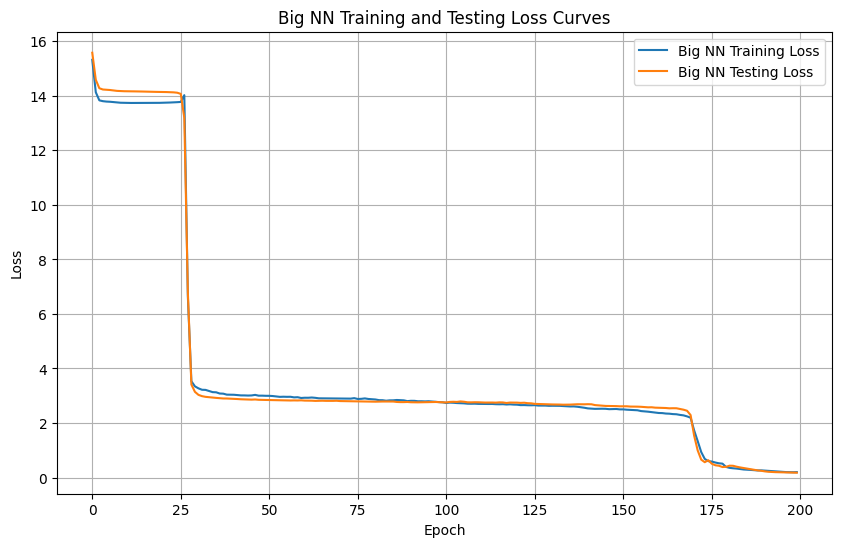

In [ ]:
def draw_loss(train_loss, test_loss, title=''):
  plt.figure(figsize=(10, 6))
  plt.plot(train_loss, label=f'{title} Training Loss')
  plt.plot(test_loss, label=f'{title} Testing Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'{title} Training and Testing Loss Curves')
  plt.legend()
  plt.grid(True)
  plt.show()

draw_loss(big_train_loss, big_test_loss, title='Big NN')

In [ ]:
loss_dict["Big NN loss"] = big_test_loss[-1]
print(big_test_loss[-1])

0.17771553993225098


Training proved more challenging, resulting in lower performance.  This may necessitate extended training or additional data. Notice that the gradients at  the output layer were observed to be an order of magnitude larger than those at the input layer.

# 2. Regularization and Normalization techniques




## 2.1 Gradient vanishing and explosion

Consider the multiplication of diagonal matrices: $$W = W_1 W_2 \dots W_n.$$ If the eigenvalues of each $W_i$ are less than 1, then the product $W$ will quickly converge to a small matrix. Conversely, if the eigenvalues of each $W_i$  are greater than 1, the product $W$ will grow exponentially.

With Neural Networks it lead to the idea, that on each layers *parameters* and *gradients* should ideally <ins>be kept within a reasonable range or normalized</ins>.

## 2.2 Initialization of Layers

Here are a few tips for initializing layer weights:

1. **Default Initialization**: Often, you don't need to explicitly initialize weights; PyTorch may provide reasonable defaults.
2. **He Initialization**: A common approach is to initialize weights within the range $[-y, y]$, where $y = \frac{1}{\sqrt{n}}$ and 'n' is the number of inputs to a neuron.
3. **Xavier Initialization**: Xavier initialization is theoretically well-founded in certain situations ([Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010)](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)).

PyTorch Docs:
https://pytorch.org/docs/stable/nn.init.html#torch-nn-init


## 2.2 Batch Normalization

Normalization techniques aim to make data samples more similar, improving model learning and generalization. There are several normalization layers: [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) (introduced in 2015), [ instance normalization](https://pytorch.org/docs/stable/generated/torch.nn.InstanceNorm1d.html), [layer normalization ](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)

Let's consider batch normalization.

1. First, the **batch normalization layer** is applied, normalizing the current batch to have zero mean and unit variance: $$X^{k+1} = \frac{X^k-\mu}{\sqrt{\sigma^2 + \varepsilon}},$$ where $\mu$ and $\sigma^2$ are the average and variance of features for the processed batch. Note that $\mu^2$ and $\sigma^2$, being functions of $X^k$, also participate in the calculation of gradients. <ins>During inference they must be fixed</ins>.

2. A **channel-wise scaling** layer follows, learning optimal scaling for all features $X^{k+2}$. This layer applies the transformation $$X^{k+2} = \beta X^{k+1} + \gamma,$$ where $\beta$ and $\gamma$ are learnable parameters, adjusting the mean and variance of the output $X^{k+2}$ during training.

### 2.2.1 Using BN

<font color='blue'>**Question**: Should Batch Normalization precede or follow after an Activation function?</font>

The order

```
Linear → BatchNorm → Activation
```

makes more sence. As a side note, this ordering best practice is not a law. With other order your model will still train, and you may see better results.

In [ ]:
dim = 3
input_size, hidden_size, output_size = dim * (dim + 1) // 2, 32, dim

big_model_BN = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(big_model_BN.parameters(), lr=0.001)
train_loss_BN, test_loss_BN = training_loop(big_model_BN, X_train_scaled, y_train,
                                              X_test_scaled, y_test,
                                              criterion, optimizer,
                                              print_grad=True)

 10%|█         | 10/100 [00:07<01:16,  1.18it/s]

 Epoch [10/100], Loss: 0.4478
Layer: 0.weight, Gradient: 3.9195220470428467
Layer: 0.bias, Gradient: 1.6779122352600098
Layer: 1.weight, Gradient: 0.7699037790298462
Layer: 1.bias, Gradient: 0.7617533206939697
Layer: 3.weight, Gradient: 8.711344718933105
Layer: 3.bias, Gradient: 2.6877691745758057
Layer: 4.weight, Gradient: 1.2992795705795288
Layer: 4.bias, Gradient: 0.8547844290733337
Layer: 6.weight, Gradient: 9.351181983947754
Layer: 6.bias, Gradient: 1.9768787622451782
Layer: 7.weight, Gradient: 1.2370530366897583
Layer: 7.bias, Gradient: 0.6316713690757751
Layer: 9.weight, Gradient: 8.897383689880371
Layer: 9.bias, Gradient: 1.3793069124221802
Layer: 10.weight, Gradient: 1.2401363849639893
Layer: 10.bias, Gradient: 0.4954897165298462
Layer: 12.weight, Gradient: 8.347525596618652
Layer: 12.bias, Gradient: 1.0102355480194092
Layer: 13.weight, Gradient: 1.169914722442627
Layer: 13.bias, Gradient: 0.34129324555397034
Layer: 15.weight, Gradient: 8.218841552734375
Layer: 15.bias, Gradie

 30%|███       | 30/100 [00:22<00:50,  1.39it/s]

 Epoch [30/100], Loss: 0.1829
Layer: 0.weight, Gradient: 2.265679359436035
Layer: 0.bias, Gradient: 1.5318351984024048
Layer: 1.weight, Gradient: 0.8327119946479797
Layer: 1.bias, Gradient: 0.717663586139679
Layer: 3.weight, Gradient: 4.757472038269043
Layer: 3.bias, Gradient: 1.476988673210144
Layer: 4.weight, Gradient: 0.9595667719841003
Layer: 4.bias, Gradient: 0.5504750609397888
Layer: 6.weight, Gradient: 5.3459248542785645
Layer: 6.bias, Gradient: 0.935809314250946
Layer: 7.weight, Gradient: 0.860689103603363
Layer: 7.bias, Gradient: 0.36889469623565674
Layer: 9.weight, Gradient: 5.394071102142334
Layer: 9.bias, Gradient: 0.616981029510498
Layer: 10.weight, Gradient: 0.7921175360679626
Layer: 10.bias, Gradient: 0.22435392439365387
Layer: 12.weight, Gradient: 7.2351531982421875
Layer: 12.bias, Gradient: 0.6075985431671143
Layer: 13.weight, Gradient: 1.1596884727478027
Layer: 13.bias, Gradient: 0.22529661655426025
Layer: 15.weight, Gradient: 6.934790134429932
Layer: 15.bias, Gradien

 50%|█████     | 50/100 [00:36<00:33,  1.48it/s]

 Epoch [50/100], Loss: 0.1041
Layer: 0.weight, Gradient: 1.3860697746276855
Layer: 0.bias, Gradient: 0.5478296279907227
Layer: 1.weight, Gradient: 0.4249970316886902
Layer: 1.bias, Gradient: 0.3024946451187134
Layer: 3.weight, Gradient: 2.4896411895751953
Layer: 3.bias, Gradient: 0.6101853847503662
Layer: 4.weight, Gradient: 0.33515068888664246
Layer: 4.bias, Gradient: 0.2023598998785019
Layer: 6.weight, Gradient: 3.129652500152588
Layer: 6.bias, Gradient: 0.39673036336898804
Layer: 7.weight, Gradient: 0.4243607819080353
Layer: 7.bias, Gradient: 0.1364288628101349
Layer: 9.weight, Gradient: 2.8636484146118164
Layer: 9.bias, Gradient: 0.24769514799118042
Layer: 10.weight, Gradient: 0.3206210732460022
Layer: 10.bias, Gradient: 0.0959853082895279
Layer: 12.weight, Gradient: 2.8564743995666504
Layer: 12.bias, Gradient: 0.18614619970321655
Layer: 13.weight, Gradient: 0.3323814868927002
Layer: 13.bias, Gradient: 0.06600887328386307
Layer: 15.weight, Gradient: 2.5076308250427246
Layer: 15.bia

 70%|███████   | 70/100 [00:51<00:20,  1.48it/s]

 Epoch [70/100], Loss: 0.0647
Layer: 0.weight, Gradient: 1.098150610923767
Layer: 0.bias, Gradient: 0.4232061803340912
Layer: 1.weight, Gradient: 0.281130850315094
Layer: 1.bias, Gradient: 0.2241591364145279
Layer: 3.weight, Gradient: 1.847737431526184
Layer: 3.bias, Gradient: 0.44103577733039856
Layer: 4.weight, Gradient: 0.26375120878219604
Layer: 4.bias, Gradient: 0.1517755538225174
Layer: 6.weight, Gradient: 2.246220827102661
Layer: 6.bias, Gradient: 0.27625414729118347
Layer: 7.weight, Gradient: 0.25691118836402893
Layer: 7.bias, Gradient: 0.09747707843780518
Layer: 9.weight, Gradient: 2.1158721446990967
Layer: 9.bias, Gradient: 0.17600440979003906
Layer: 10.weight, Gradient: 0.23523449897766113
Layer: 10.bias, Gradient: 0.06365859508514404
Layer: 12.weight, Gradient: 2.0426900386810303
Layer: 12.bias, Gradient: 0.10884661227464676
Layer: 13.weight, Gradient: 0.2136005461215973
Layer: 13.bias, Gradient: 0.04194994643330574
Layer: 15.weight, Gradient: 1.7228937149047852
Layer: 15.b

 90%|█████████ | 90/100 [01:05<00:06,  1.48it/s]

 Epoch [90/100], Loss: 0.0643
Layer: 0.weight, Gradient: 1.2260242700576782
Layer: 0.bias, Gradient: 0.696722686290741
Layer: 1.weight, Gradient: 0.43697357177734375
Layer: 1.bias, Gradient: 0.348683625459671
Layer: 3.weight, Gradient: 2.577063798904419
Layer: 3.bias, Gradient: 0.8098661303520203
Layer: 4.weight, Gradient: 0.5280788540840149
Layer: 4.bias, Gradient: 0.27683138847351074
Layer: 6.weight, Gradient: 3.1690094470977783
Layer: 6.bias, Gradient: 0.5417612195014954
Layer: 7.weight, Gradient: 0.5827967524528503
Layer: 7.bias, Gradient: 0.1807558387517929
Layer: 9.weight, Gradient: 3.467517852783203
Layer: 9.bias, Gradient: 0.3742772042751312
Layer: 10.weight, Gradient: 0.5389940142631531
Layer: 10.bias, Gradient: 0.133405864238739
Layer: 12.weight, Gradient: 3.6826720237731934
Layer: 12.bias, Gradient: 0.2784002125263214
Layer: 13.weight, Gradient: 0.6020382046699524
Layer: 13.bias, Gradient: 0.0974772498011589
Layer: 15.weight, Gradient: 3.7608110904693604
Layer: 15.bias, Grad

100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


While the loss increased slightly, the training curve became significantly smoother. Very deep NN can not be trained without normalization techniques.

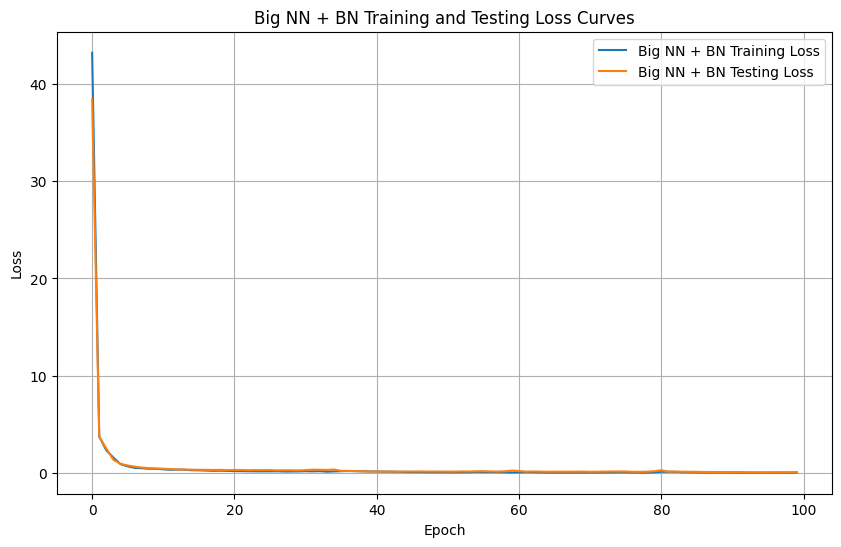

In [ ]:
draw_loss(train_loss_BN, test_loss_BN, title='Big NN + BN')

In [ ]:
loss_dict["Simple NN + BN loss"] = test_loss_BN[-1]
print(test_loss_BN[-1])

0.11099393665790558


Batch normalization's effectiveness is still a mystery.  Numerous hypotheses exist, but no definitive explanation has emerged.  This uncertainty is common in deep learning, best practices are usually found in experiments rather than in theory.

## 2.3 Dropout

Another problem with big NN is that they can easily **overfit**. Once overfitting begins, the focus shifts to improving generalization through regularization. Standard strategies include:

1.   reducing model capacity,
2.   early stopping,
3.   weight regularization,
4.   and **dropout**.

As a side note, a larger or higher-quality dataset remains the most effective way to enhance generalization.

**Dropout**, applied to a layer, consists of randomly dropping out
(setting to zero) a number of output features of the layer during training.

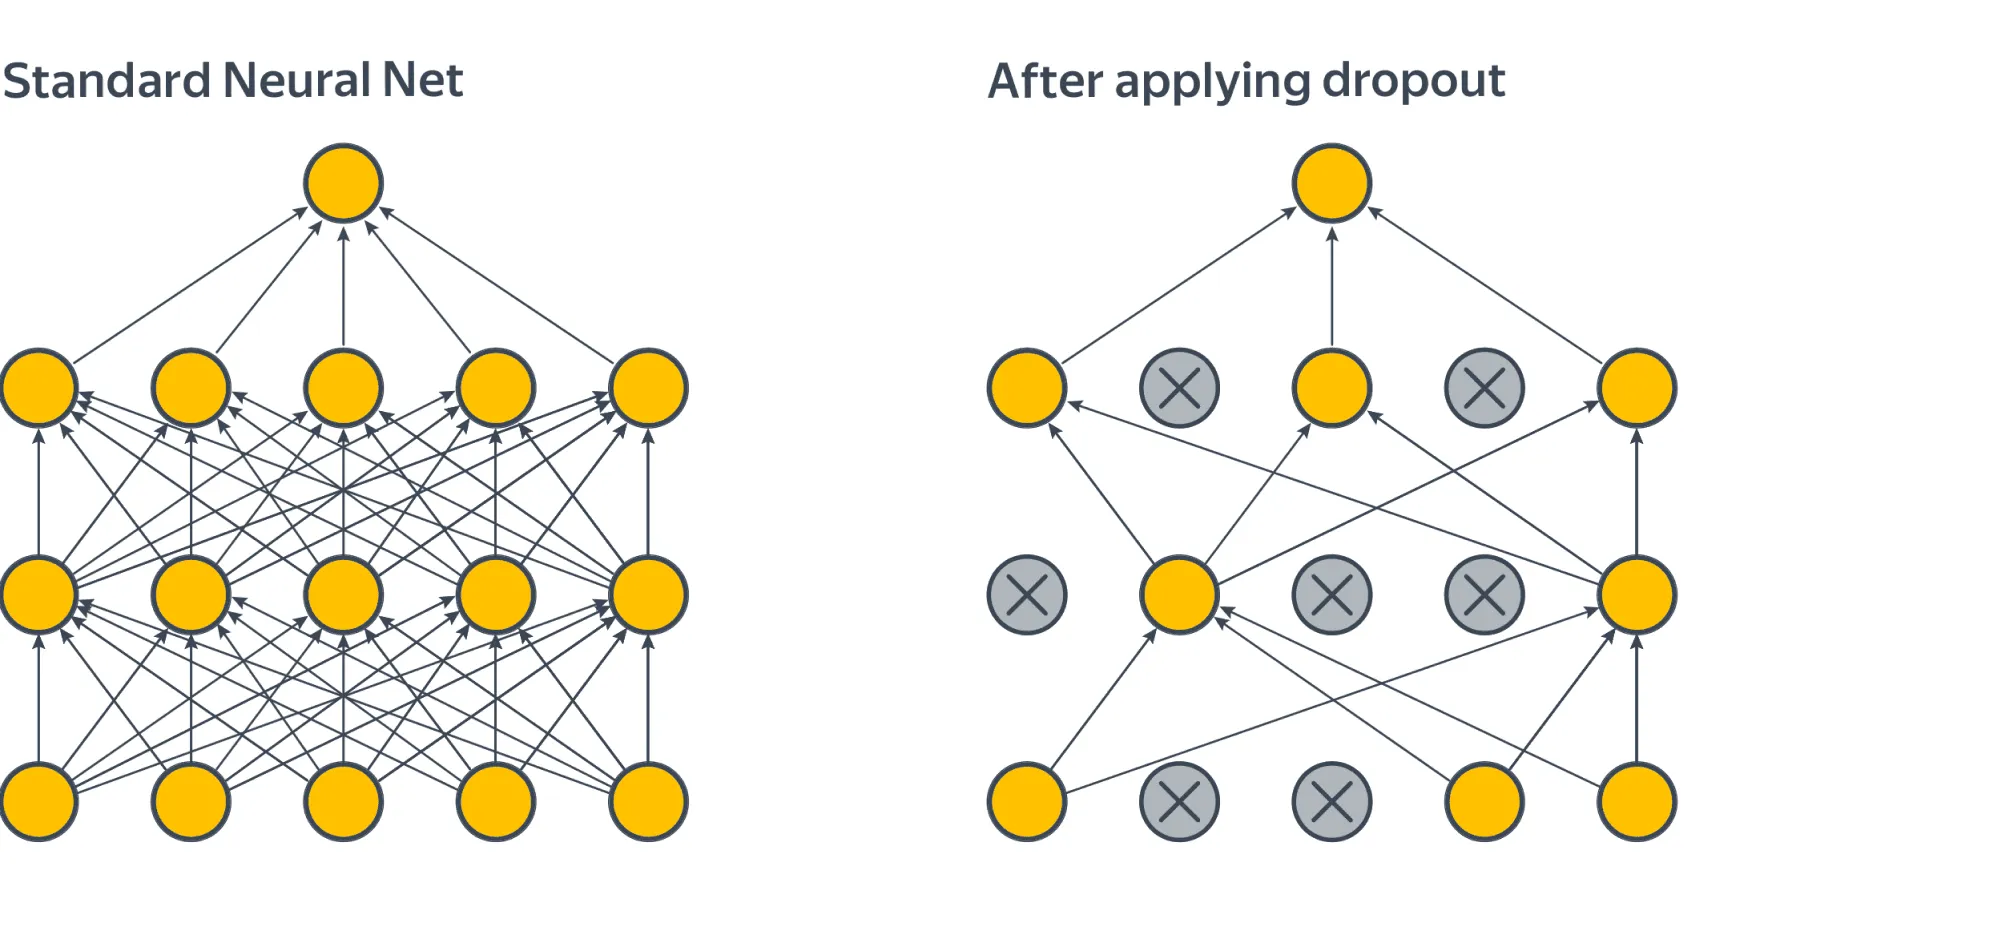

Techinically another transformation is added, which is the multiplication of the output of the previous layer by a mask of zeros and ones. $$x_{k+1} = \frac{1}{1-p}x^k \odot mask_i, \qquad mask_i \sim \operatorname{Bernoulli}(1-p),$$ where $p$ (probability of coordinate zeroing) is the hyperparameter of the layer. <ins>On inference dropout must be turn-off</ins> (also, note that we multiply on $\frac{1}{1-p}$, to balance for the fact that more units are
active than at training time).


<font color='blue'>**Question**: Why would this help reduce overfitting?</font>

Drop-out was introduced in 2014 by Geoff Hinton and his student. He described the idea behind the Drop-out as follows:

> “I went to my bank. The tellers kept changing
and I asked one of them why. He said he didn’t know but they got moved around a lot I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different
subset of neurons on each example would prevent conspiracies and thus reduce overfitting.”


In [ ]:
dim = 3
input_size, hidden_size, output_size = dim * (dim + 1) // 2, 32, dim

big_model_DO = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, output_size)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(big_model_DO.parameters(), lr=0.001)
train_loss_DO, test_loss_DO = training_loop(big_model_DO, X_train_scaled, y_train,
                                              X_test_scaled, y_test,
                                              criterion, optimizer, num_epochs=200, print_grad=False)

  5%|▌         | 10/200 [00:04<01:22,  2.29it/s]

 Epoch [10/200], Loss: 13.6900


 15%|█▌        | 30/200 [00:14<01:14,  2.28it/s]

 Epoch [30/200], Loss: 2.9367


 25%|██▌       | 50/200 [00:23<01:08,  2.18it/s]

 Epoch [50/200], Loss: 2.7479


 35%|███▌      | 70/200 [00:32<01:13,  1.76it/s]

 Epoch [70/200], Loss: 2.6651


 45%|████▌     | 90/200 [00:41<00:46,  2.35it/s]

 Epoch [90/200], Loss: 2.3767


 55%|█████▌    | 110/200 [00:51<00:39,  2.27it/s]

 Epoch [110/200], Loss: 2.3260


 65%|██████▌   | 130/200 [01:01<00:31,  2.24it/s]

 Epoch [130/200], Loss: 2.0663


 75%|███████▌  | 150/200 [01:10<00:27,  1.83it/s]

 Epoch [150/200], Loss: 0.2441


 85%|████████▌ | 170/200 [01:19<00:13,  2.30it/s]

 Epoch [170/200], Loss: 0.1368


 95%|█████████▌| 190/200 [01:29<00:04,  2.20it/s]

 Epoch [190/200], Loss: 0.1059


100%|██████████| 200/200 [01:33<00:00,  2.13it/s]


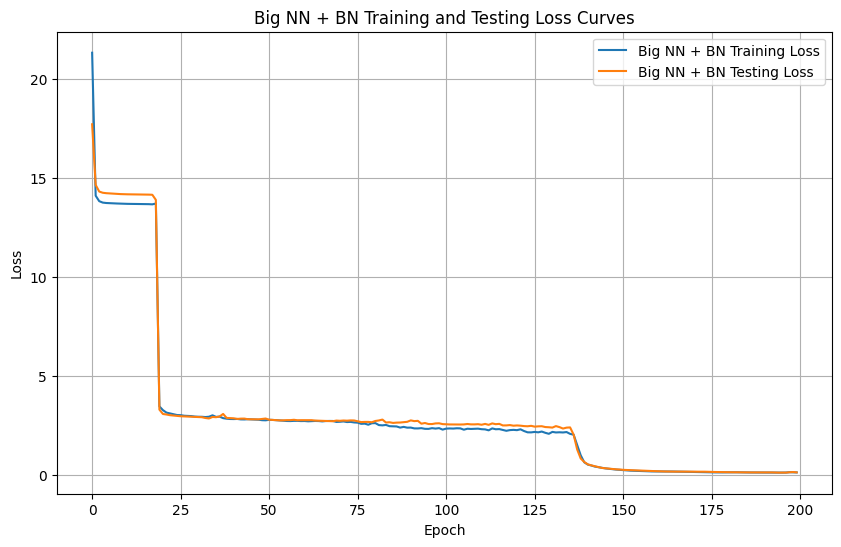

In [ ]:
draw_loss(train_loss_DO, test_loss_DO, title='Big NN + BN')

In [ ]:
loss_dict["Simple NN + DO loss"] = test_loss_DO[-1]
test_loss_DO[-1]

0.11616747826337814

This time Dropout only made the situation worse. BN and Dropout may not go well together. As the creators of BatchNormalization noted (https://arxiv.org/pdf/1502.03167):

>"Whereas Dropout is typically used to reduce overfitting, a batch-normalized network we found that it can be either removed or reduced in strength".

  5%|▌         | 10/200 [00:07<02:16,  1.40it/s]

 Epoch [10/200], Loss: 0.5097


 15%|█▌        | 30/200 [00:22<01:56,  1.45it/s]

 Epoch [30/200], Loss: 0.1491


 25%|██▌       | 50/200 [00:37<02:00,  1.24it/s]

 Epoch [50/200], Loss: 0.0995


 35%|███▌      | 70/200 [00:52<01:41,  1.28it/s]

 Epoch [70/200], Loss: 0.0701


 45%|████▌     | 90/200 [01:07<01:17,  1.41it/s]

 Epoch [90/200], Loss: 0.0565


 55%|█████▌    | 110/200 [01:22<01:09,  1.30it/s]

 Epoch [110/200], Loss: 0.0622


 65%|██████▌   | 130/200 [01:37<00:49,  1.43it/s]

 Epoch [130/200], Loss: 0.0546


 75%|███████▌  | 150/200 [01:52<00:40,  1.23it/s]

 Epoch [150/200], Loss: 0.0346


 85%|████████▌ | 170/200 [02:07<00:23,  1.30it/s]

 Epoch [170/200], Loss: 0.0392


 95%|█████████▌| 190/200 [02:21<00:07,  1.41it/s]

 Epoch [190/200], Loss: 0.0792


100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


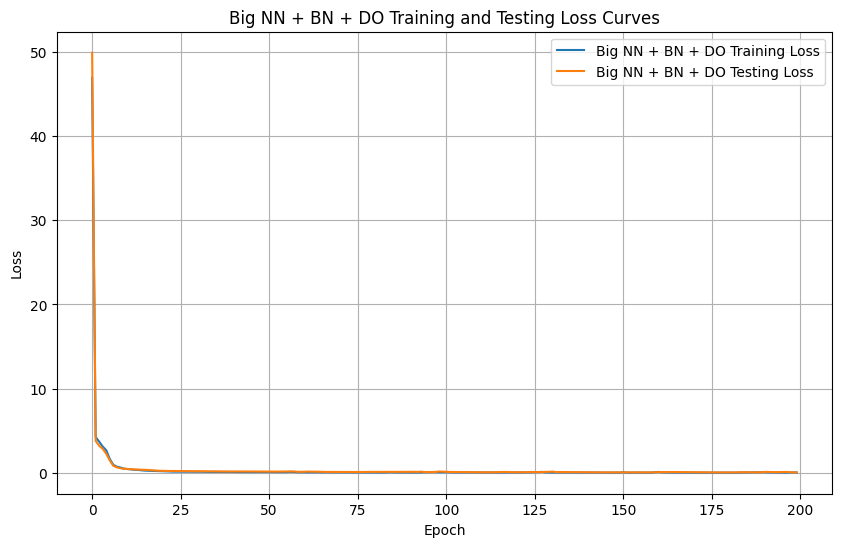

0.0630914494395256

In [ ]:
dim = 3
input_size, hidden_size, output_size = dim * (dim + 1) // 2, 32, dim

big_model_BN_DO = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, output_size)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(big_model_BN_DO.parameters(), lr=0.001)
train_loss_BN_DO, test_loss_BN_DO = training_loop(big_model_BN_DO, X_train_scaled, y_train,
                                              X_test_scaled, y_test,
                                              criterion, optimizer, num_epochs=200, print_grad=False)

draw_loss(train_loss_BN_DO, test_loss_BN_DO, title='Big NN + BN + DO')
test_loss_BN_DO[-1]


In [ ]:
loss_dict["Simple NN + BN + DO loss"] = test_loss_BN_DO[-1]

loss_df = pd.DataFrame.from_dict(loss_dict, orient='index', columns=['Loss'])

loss_df

# for key, value in loss_dict.items():
    # print(f"{key}: {value}")

,Loss
Poly reg loss,0.134815
Simple NN loss,0.073390
Big NN loss,0.177716
Simple NN + BN loss,0.110994
Simple NN + DO loss,0.116167
Simple NN + BN + DO loss,0.063091



### Key takeaways:

1. Address potential **gradient vanishing/explosion** by using appropriate initialization, batch normalization, and dropout.
2. Larger neural networks do not always guarantee better performance.


<font color='red'>**Advice:**</font>

1. When available, <ins>leverage parameters from relevant research publications</ins> as a starting point.
2. Start with a basic neural network architecture and gradually increase its complexity, adding one component at a time.
